# Monte Carlo Methods

In this exercise, we will look at Monte Carlo (MC) methods.

In the last exercise, we did policy iteration to obtain the optimal policy. For that we had a model of the environment where we could sample any state and action and observe the reward and the new state. Often, we do not have this information available, but only have actual (or simulated) experience, i.e. sample sequences of states, actions and rewards. In Monte Carlo (MC) methods we can learn directly from this experience. 

MC methods are characterized that we update our estimations of state value or state-action value functions only at the end of an episode. In the next chapter we will look at methods that perform updates sooner.

We will implement the following:
* `generate_episode`: function to generate one episode
* `monte_carlo_prediction`: calculate MC prediction for the state-value function given a policy
* `generate_episode_with_actions`: function to generate one episode and also return the actions
* `monte_carlo_predict_action_value`: calculate MC predition for the action-value function given a policy
* `greedy_from_action_values`: function to calculate greedy policy from the action-value function
* `MonteCarloAgentFirstVisit`: class for Agent trained with MC

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import gymnasium as gym

import sys

sys.path.append('.')
from mdp import RState, MDPGridworld, WalledGridworld, SlipperyGridworld
from util import max_arg_with_ties, plot_policy_values

## MDP, gridworld and agent environments

We will use a gym based environment for our MDP in this and the next exercise (as in the first exercise with the multi-armed bandit). For the implementation inside the env we still use the already implemented MDP class that we used for the dynamic programming exercise. We use the different gridworld environments to set up the MDPs.

The gym.Env environment simulates the task more adequatly, as we can only input the next action for an agent passing through the gridworld MDP and it also allows us to use different training algorithm with the same interface.

We will use the latest implementation as described in
[https://gymnasium.farama.org/index.html](https://gymnasium.farama.org/index.html)


In [3]:
class MDPEnv(gym.Env):
    """
    Environment around an MDP which is given at initialization. The env contains the current state
    of the agent and will update it according to the actions. The agent is only able to observe the new state after its action.

    The initial position and the position after reset is given in the initializer.
    """

    def __init__(self, states: [RState], nr_actions: int, start_state_id: int):
        """
        Initialize the environment.
        Args:
            states:  list of states in the MDP
            nr_actions: the (maximal) number of actions for a state in the MDP
            start_state_id: id of the start state
        """
        # we keep a reference to the states for the interaction
        self._states = states

        # the start state and current state
        self._start_state_id = start_state_id
        self._current_state = self._states[self._start_state_id]

        # action space consists of moving in each direction
        self.action_space = gym.spaces.Discrete(nr_actions)

        # The observation is the id of the state after the action
        self.observation_space = gym.spaces.Discrete(len(states))

    def step(self, action: int) -> tuple[int, float, bool, bool, dict]:
        """

        Args:
            action: The action to take
        Returns:
            observation: the observation due to the agent's action
            reward: the reward as a result of the action
            terminated (bool): whether the agent reaches a terminal state
            truncated (bool): whether the episode is truncated due to the maximum number of steps
            info (dict): additional information
        """
        self._current_state, reward = self._current_state.take_action(action)
        return self._current_state.state_id, reward, self._current_state.is_terminal, False, {}

    def reset(self) -> tuple[int, dict]:
        """
        Reset the environment to the initial state.
        Returns:
            observation: the observation of the initial state
            info (dict): additional information
        """
        self._current_state = self._states[self._start_state_id]
        return self._current_state.state_id, {}

    def render(self, mode='human'):
        pass


Similar to the first exercise we will use an agent class that should learn choosing the best actions, i.e. the best policy. For comparison, we again implement a random agent first.

Our discrete agent will need to use tables for the state value or state-action value function, so we will pass the action and state spaces from the environment.

We add a train function in the agent this time for training the agent in a specific environment. The action space must be compatible to the action space of the environment.

In [4]:
class Agent:
    """
    Class for an agent in our env.
    """

    def __init__(self, action_space, state_space):
        self._action_space = action_space
        self._state_space = state_space

    def reset(self) -> (int, int):
        """
        Reset the learning of the agent to an initial condition, so it can be used again, for example to
        compare different runs.
        """
        raise NotImplementedError

    def step_first(self, observation):
        """
        First step after reset or initialization with the first observation from the environment.
        Args:
            observation: the current position of the agent
        Returns:
            the action for the first step
        """
        raise NotImplementedError

    def step(self, observation, reward: float, done: bool):
        """
        Step in the environment. The reward given is the returned reward from the last action.
        Args:
            observation: the current position of the agent
            reward: the reward obtained from the last action
            done: the done returned from the last action on the environment (signals the end of an episode)
        Returns:
            the action
        """
        raise NotImplementedError

    def train(self, env: gym.Env, nr_episodes: int):
        """
        Train the agent in the given environment
        Args:
            env: the env to train the agent on
            nr_episodes: number of episodes to train.
        """
        raise NotImplementedError


class RandomAgent(Agent):

    def reset(self):
        pass

    def step_first(self, observation):
        # return a random action
        return np.random.randint(self._action_space.n)

    def step(self, observation, reward, done):
        # return a random action
        return np.random.randint(self._action_space.n)

    def train(self, env: gym.Env, nr_episodes: int):
        # nothing to train here
        pass



    

## Gridworld environment

We will setup a gridworld as in the last example. We use a simpler gridworld in the beginning and will make some experiments with the one from the last exercise later as MC methods take longer to calculate.

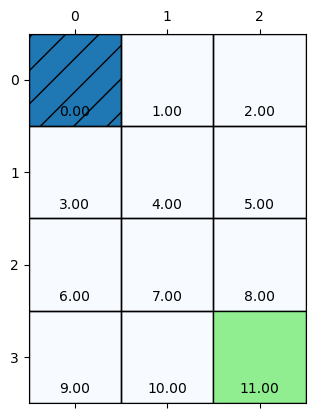

In [5]:
gw = MDPGridworld(height=4, width=3)
gw.state(0,0).is_terminal = True
gw.state(3,2).color = 'lightgreen'

fig, ax = plt.subplots()
gw.render(gw.all_state_ids(), ax)


In [6]:
# Here is an example how to use just the env and agent classes to produce an episode using the random agent

env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = RandomAgent(env.action_space, env.observation_space)

obs, _ = env.reset()
visited_states = [obs]
g = 0.0
# try one sample episode
action = agent.step_first(obs)
done = False
while not done:
    obs, reward, done, _, _ = env.step(action)
    visited_states.append(obs)
    g += reward
    action = agent.step(obs, reward, done)

print(f'Visited states: {visited_states}')
print(f'Total return: {g}') 

Visited states: [11, 11, 11, 8, 8, 11, 10, 7, 6, 6, 3, 0]
Total return: -11.0


## Monte Carlo prediction

Before implementing the agent, we will look at some standalone algorithms that we can then use as blueprints for implementing an agent.

First, we want to start Monte Carlo methods with prediction. So we want to estimate the value function v(s) for a given policy and use the first visit MC as described on page 92 in the book or in the slides.

In order to do this, let us write a function that generates one complete episode and returns a list of states and rewards that were visited in the episode.

In [7]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
init_state = env.reset()
init_state

(11, {})

In [8]:
def generate_episode(env: gym.Env, policy: np.ndarray) -> ([], []):
    """
    Reset the environment and generate an episode using the policy p. Return the list of states and rewards.
    Args:
        env: the environment to use
        policy: the policy

    Returns:
        The list of states visited and the rewards obtained
    """
    states = []
    rewards = []

    # reset the environment and add the observation (a state) to the states, then calculate the first action
    # according to p

    # you can use the function np.random.choice and supply its argument p to draw actions according to the policy

    state, _ = env.reset()
    states.append(state)
    
    done = False

    # now continue until the episode is done
    # YOUR CODE HERE
    while not done:
        action = np.random.choice(policy.shape[1], p = policy[state,:])
        state, rew, done,_ ,_ = env.step(action)
        if  done:
            break
        states.append(state)
        rewards.append(rew)

    rewards.append(rew)
    

    return states, rewards

In [9]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)

# random policy
p = np.zeros((len(gw.states), gw.NR_ACTIONS))
p.fill(1.0/gw.NR_ACTIONS)

np.random.seed(1)
states, rewards = generate_episode(env, p)
print(states)
print(rewards)
# should have at least one state
assert len(states) > 0
# same number of rewards than states
assert len(states) == len(rewards)
# all rewards are -1.0 
assert np.all(np.array(rewards) == -1.0)
# the terminal state should not be included in the list
for s in states:
    assert (not gw.states[s].is_terminal)


[11, 11, 8, 5, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1]
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


## MC Prediction of state-value function

We can now calculate the Monte Carlo prediction using the generated episodes. Complete the function below to calculate the state-value prediction from a given episode.

In [10]:
def monte_carlo_prediction(env: gym.Env,
                           nr_states: int,
                           policy: np.ndarray,
                           gamma: float,
                           num_repetitions: int) -> np.ndarray:
    """
    Estimate the value function for the environment for the given policy p
    Args:
        env: the environment for interaction
        nr_states: the number of states in the MDP of the environment
        policy: the policy to evaluate
        gamma: the discount factor
        num_repetitions: The number of repetitions for training

    Returns:
        the state-value function for the policy
    """

    # as in the slides we keep all returns for a state and initialize them to an empty list
    returns = np.empty(nr_states, dtype=object)
    for s_id in range(nr_states):
        returns[s_id] = []

    for _ in range(num_repetitions):
        # generate a full episode and add the states and rewards
        states, rewards = generate_episode(env, policy)

        # now we should go back in reverse order and update the total return, going in reverse avoids
        # summing the rewards multiple times
        #
        # careful: only update states that have not yet appeared in the episode before (first visit MC)
        g = 0.0
        state_rewards = np.zeros(policy.shape[0])
        for step in reversed(range(len(states))):
            g = gamma * g + rewards[step]
            state_rewards[states[step]] = g

            
        for index, state in enumerate(state_rewards):
            returns[index].append(state)
    # it is sufficient here to calculate v at the end, as we do not use it in the algorithm,
    # i.e. the policy is given and does not depend on v
    v = np.zeros(nr_states)
    # calculate v as mean value of all returns at each state

    # YOUR CODE HERE
    for index, state_returns in enumerate(returns):
        non_zero_returns = [r for r in state_returns if r != 0]  # Filter out zeros
        v[index] = np.mean(non_zero_returns) if non_zero_returns else 0  # Avoid NaN
    
    print(v)
    return v



In [11]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)

# random policy
p = np.zeros((len(gw.states), gw.NR_ACTIONS))
p.fill(1.0 / gw.NR_ACTIONS)

np.random.seed(1)
v = monte_carlo_prediction(env, nr_states=len(gw.states), policy=p, gamma=1.0, num_repetitions=1000)

# value function at terminal states must be 0
assert v[0] == 0.0

# MC with 1000 iterations will still vary a bit around the result, this comparison should also work with different seeds or usages
# of the random generator
np.testing.assert_allclose(
        [0., -21.13, -29.76, -21.42, -28.98, -32.25, -33.54, -36.74, -38.02, -39.22, -39.66, -40.784], v, atol=5.0)

# test with different gamma
v2 = monte_carlo_prediction(env, nr_states=len(gw.states), policy=p, gamma=0.9, num_repetitions=1000)
np.testing.assert_allclose([0.0, -5.2, -7.0, -5.8, -7.0, -7.9, -8.0, -8.3, -8.6, -8.7, -8.8, -8.9], v2 , atol=2.0)



[  0.         -21.1344     -29.76436782 -21.42536328 -28.9830303
 -32.25828729 -33.54228188 -36.74163783 -38.02900232 -39.22033898
 -39.66227545 -40.784     ]
[ 0.         -5.21915791 -7.07489312 -5.83302714 -7.09648246 -7.90794539
 -8.0704563  -8.35398796 -8.63345972 -8.72602328 -8.83817206 -8.93193959]


Let us look at the result with gamma = 1.0 and gamma = 0.9

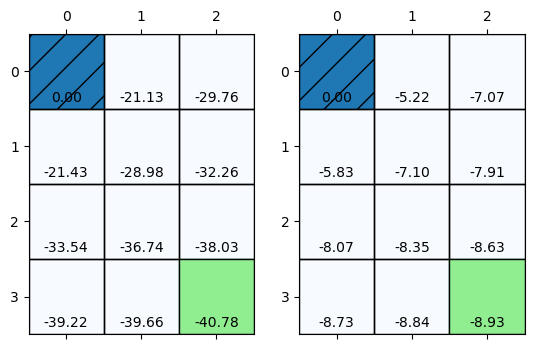

In [12]:
fig, axs = plt.subplots(ncols=2)
gw.render(v, axs[0])
gw.render(v2, axs[1])


## Estimating action values

We would now like to implement the Monte Carlo Agent for estimating the best policy. Unfortunately the value functions is not so helpful for calculating a (greedy) policy as we can not maximize over all possible actions.

It is therefor better to estimate the action-value function, from which we can then calculate a greedy policy.

As a first step, implement the generate_episode function again, this times with also returning the actions.




In [13]:
def generate_episode_with_actions(env: gym.Env, p) -> ([],[],[]):
    """
    Reset the environment and generate an episode using the policy p. Return the list of states, actions and rewards.
    Args:
        env: the environment
        p: the policy
    Returns:
        lists of states, rewards and actions
    """
    states = []
    rewards = []
    actions = []

    # reset the environment and add the observation (a state) to the states, then calculate the first action
    # according to p

    state, _ = env.reset()
    states.append(state)
    
    done = False

    # now continue until the episode is done
    # YOUR CODE HERE
    while not done:
        action = np.random.choice(p.shape[1], p = p[state,:])
        actions.append(action)
        state, rew, done,_ ,_ = env.step(action)
        if  done:
            break
        states.append(state)
        rewards.append(rew)

    rewards.append(rew)


    return states, actions, rewards


In [14]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)

# random policy
p = np.zeros((len(gw.states), gw.NR_ACTIONS))
p.fill(1.0/gw.NR_ACTIONS)

np.random.seed(1)
states, actions, rewards = generate_episode_with_actions(env, p)
# should have at least one state
assert len(states) > 0
# same number of actions than states
assert len(actions) == len(states)


## MC prediction of action-value function

Now modify the prediction function to predict the action-value function.

In [15]:
def monte_carlo_predict_action_value(env: gym.Env,
                                     nr_states: int,
                                     policy: np.ndarray,
                                     gamma: float,
                                     num_repetitions: int) -> np.ndarray:
    """
    Estimate the action value function for the environment for the given policy
    Args:
        env: the environment for interaction
        nr_states: the number of states in the MDP of the environment
        policy: the policy to evaluate
        gamma: the discount factor
        num_repetitions: the number of repetitions for training
    Returns:
        the action-value function for the policy
    """
    # we keep all returns for a state/action pair and initialize them to an empty list
    nr_actions = env.action_space.n
    matrix_stack = []
    returns = np.empty((nr_states, nr_actions), dtype=object)
    for s_id in range(nr_states):
        for a in range(env.action_space.n):
            returns[s_id, a] = []

    for _ in range(num_repetitions):
        # generate a full episode and add the states and rewards
        states, actions, rewards = generate_episode_with_actions(env, policy)

        # now we should go back in reverse order and update the total return
        # careful: only update states that have not yet appeared in the episode (first visit MC)
        g = 0.0
        #print ("states: " + str(states))
        #print("actions: " + str(actions))
        #print("rewards: " + str(rewards))
        state_rewards = np.zeros((policy.shape[0], policy.shape[1]))
        for step in reversed(range(len(states))):
            g = gamma * g + rewards[step]
            state_rewards[states[step], actions[step]] = g

        matrix_stack.append(state_rewards)

    # it is sufficient here to calculate q at the end, as we do not use it in the algorithm
    q = np.zeros(returns.shape)
    # calculate q as mean value of all returns at each state
    # YOUR CODE HERE
    matrix_stack = np.array(matrix_stack)  # In NumPy-Array umwandeln
    matrix_stack[matrix_stack == 0] = np.nan  # Alle 0-Werte durch NaN ersetzen
    q = np.nanmean(matrix_stack, axis=0)  # Mittelwert ohne Nullen berechnen
    q = np.nan_to_num(q, nan=0.0)  # Alle NaN-Werte durch 0 ersetzen

    print(q)
    return q

    

In [16]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)

# random policy
p = np.zeros((len(gw.states), gw.NR_ACTIONS))
p.fill(1.0/gw.NR_ACTIONS)


np.random.seed(1)
q = monte_carlo_predict_action_value(env, nr_states=len(gw.states), policy=p, gamma=1.0, num_repetitions=1000)
# value function at terminal states must be 0
assert q[0, 0] == 0.0
# value function at one besides the terminal state should be correct
assert q[1,3] == -1.0

q2 = monte_carlo_predict_action_value(env, nr_states=len(gw.states), policy=p, gamma=0.9, num_repetitions=1000)

/tmp/ipykernel_2469/1922068371.py:48: RuntimeWarning: Mean of empty slice
  q = np.nanmean(matrix_stack, axis=0)  # Mittelwert ohne Nullen berechnen


[[  0.           0.           0.           0.        ]
 [-22.27715356 -33.64285714 -31.76595745  -1.        ]
 [-30.95017794 -30.72161172 -38.26627219 -22.05343511]
 [ -1.         -29.26197183 -33.73831776 -23.21352313]
 [-22.62131519 -34.48120301 -38.85819071 -22.43710021]
 [-30.5        -35.70918367 -41.3539604  -29.21126761]
 [-22.19813084 -37.0491453  -39.16121495 -34.41457286]
 [-31.98381295 -39.25607477 -41.97750511 -34.80747664]
 [-33.87439614 -39.34319527 -43.38814532 -37.58139535]
 [-34.51509434 -41.45894737 -39.17026379 -39.59220779]
 [-37.67159278 -41.8915009  -40.27504912 -39.66489362]
 [-39.24320828 -42.43064516 -42.54796748 -40.30366492]]
[[ 0.          0.          0.          0.        ]
 [-5.5541613  -7.32584319 -7.36509475 -1.        ]
 [-7.41081762 -7.63011076 -8.13835874 -5.57073632]
 [-1.         -7.38667284 -8.13452806 -6.39243694]
 [-5.81105148 -8.14345829 -8.53879882 -6.03478131]
 [-7.44605729 -8.09313497 -8.81467128 -7.40133626]
 [-6.27311799 -8.54634411 -8.7790

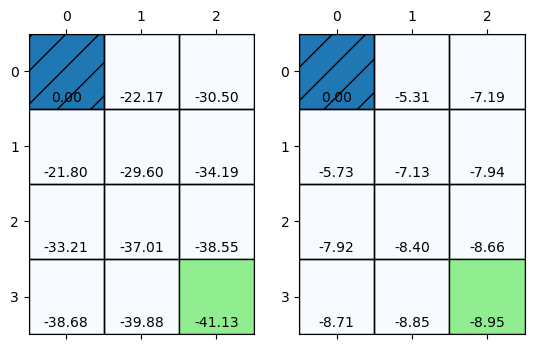

In [17]:
# if we sum over all actions (and divide by the number of actions), we again get the value function as there is the same probability for each action
fig, axs = plt.subplots(ncols=2)
gw.render(q.sum(axis=1)/4,axs[0])
gw.render(q2.sum(axis=1)/4,axs[1])

However, the best action would be the one that maximises the return. So this plot should be a bit closer to the expected result as one optimal action would be taken.


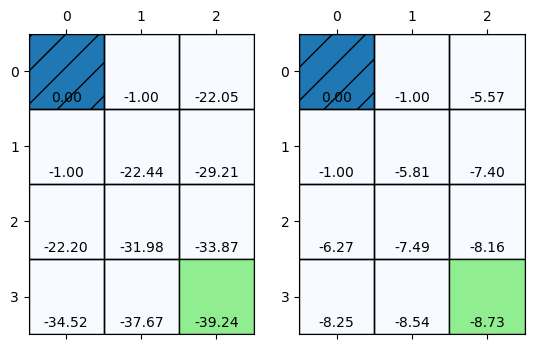

In [18]:
fig, axs = plt.subplots(ncols=2)
gw.render(q.max(axis=1),axs[0])
gw.render(q2.max(axis=1),axs[1])

## Calculation of greedy policy

Now it is possible to calculate a greedy policy from the action values. Remember that your policy function should still be an array with the probability for each action. So one of the entries will be 1 and the others will be 0 for a greedy action.

In [19]:
q

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [-22.27715356, -33.64285714, -31.76595745,  -1.        ],
       [-30.95017794, -30.72161172, -38.26627219, -22.05343511],
       [ -1.        , -29.26197183, -33.73831776, -23.21352313],
       [-22.62131519, -34.48120301, -38.85819071, -22.43710021],
       [-30.5       , -35.70918367, -41.3539604 , -29.21126761],
       [-22.19813084, -37.0491453 , -39.16121495, -34.41457286],
       [-31.98381295, -39.25607477, -41.97750511, -34.80747664],
       [-33.87439614, -39.34319527, -43.38814532, -37.58139535],
       [-34.51509434, -41.45894737, -39.17026379, -39.59220779],
       [-37.67159278, -41.8915009 , -40.27504912, -39.66489362],
       [-39.24320828, -42.43064516, -42.54796748, -40.30366492]])

In [37]:
def greedy_from_action_values(q) -> np.ndarray:
    """
    Calculate a greedy policy from the action values.
    Args:
        q: the action values
    Returns:
        the greedy policy

    """
    nr_states, nr_actions = q.shape
    policy = np.zeros((nr_states, nr_actions)) 
    best_actions = np.argmax(q, axis=1)  # Beste Aktion pro Zustand finden
    policy[np.arange(nr_states), best_actions] = 1 
    return policy

        

In [38]:
p_greedy = greedy_from_action_values(q)
assert p_greedy.shape == q.shape

p_greedy = greedy_from_action_values(q)

assert p_greedy[1,0] == 0.0
assert p_greedy[1,0] == 0.0
assert p_greedy[1,2] == 0.0
assert p_greedy[1,3] == 1.0

Let us plot the greedy policy after 1 iteration, i.e. greedy after the value function from the random policy

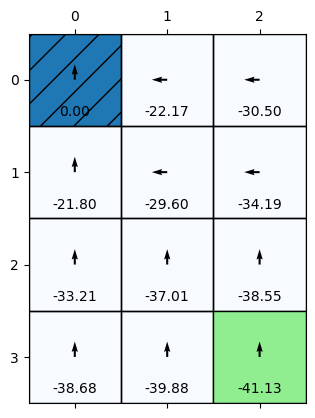

In [39]:
plot_policy_values(p_greedy, q.sum(axis=1)/4, gw)

## Agent implementation of on-policy MC control

We would now like to complete an implementation of MC control in the agent interface. While we could directly use the methods developed so far for generalized policy iterations, our implementations have used the property of the environment to produce a random start position, this is called a exploring starts algorithm. Without that feature, some of the states might not be visited at all when a (deterministic) greedy policy is used.

A possible solution is to use a policy that keeps exploring by setting the probability to any action in any state > 0. Such policies are called epsilon-soft. In more detail, we use the epsilon greedy policy that we already encountered for the multi-armed bandit problem.

The MC algorithm to implement is a so called on-policy algorithm, it follows a policy while improving it.

One other change that we will make is to update the returns incrementally instead of keeping them all in a list. We have done that already in the first exercise with the bandit agents.

Complete the code below to implement the class.

In [41]:
class MonteCarloAgentFirstVisit:
    """
    Monte Carlo Agent to implement training using first-visit MC.
    """

    def __init__(self, action_space, state_space, gamma: float, epsilon: float):
        super().__init__()
        self._epsilon = epsilon
        self._gamma = gamma
        self._action_space = action_space
        self._state_space = state_space

        self._pi = np.ones((self._state_space.n, self._action_space.n)) / self._action_space.n

        self._q = np.zeros((self._state_space.n, self._action_space.n))
        self._q_count = np.zeros((self._state_space.n, self._action_space.n), dtype=int)

        self._states = []
        self._actions = []
        self._rewards = []

    @property
    def q(self):
        return self._q

    @property
    def policy(self):
        return self._pi

    def reset(self):
        """Resets the agent to initial conditions."""
        self._q = np.zeros((self._state_space.n, self._action_space.n))
        self._pi = np.ones((self._state_space.n, self._action_space.n)) / self._action_space.n

    def step_first(self, observation) -> int:
        """First step of an episode: Selects and returns an action based on policy."""
        self._states = [observation]  
        self._actions = []
        self._rewards = []

        action = np.random.choice(self._action_space.n, p=self._pi[observation])
        self._actions.append(action)
        return action

    def step(self, observation, reward, done) -> int:
        """Handles environment feedback and updates Q-values if episode ends."""
        self._rewards.append(reward)

        if not done:
            self._states.append(observation)
            action = np.random.choice(self._action_space.n, p=self._pi[observation])
            self._actions.append(action)
            return action  

        else:
            g = 0.0
            visited = set()

            for step in reversed(range(len(self._states))):
                g = self._gamma * g + self._rewards[step]
                s, a = self._states[step], self._actions[step]

                if (s, a) not in visited:
                    visited.add((s, a))

                    self._q_count[s, a] += 1
                    alpha = 1 / self._q_count[s, a]  
                    self._q[s, a] += alpha * (g - self._q[s, a])

                    best_action = np.argmax(self._q[s, :])
                    self._pi[s, :] = self._epsilon / self._action_space.n  
                    self._pi[s, best_action] += 1 - self._epsilon

            return None 

    def train(self, env: gym.Env, nr_episodes: int):
        """Trains the agent using first-visit MC for a given number of episodes."""
        for _ in tqdm.trange(nr_episodes):
            obs, _ = env.reset()
            a = self.step_first(obs)
            done = False

            while not done:
                obs, reward, done, _, _ = env.step(a)
                a = self.step(obs, reward, done)


In [42]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = MonteCarloAgentFirstVisit(env.action_space, env.observation_space, gamma=1.0, epsilon=0.1)

# test reset
agent.reset()
assert (agent.q == 0.0).all()
assert (agent._q_count == 0).all()
assert (agent.policy == 0.25).all()

# simulate one step
a = agent.step_first(2)
assert a >= 0
assert a < 4

# simulate end of episode
a2 = agent.step(0, -1, True)
assert a2 is None

# this action was taken
assert agent._q_count[2, a] == 1
# this value was updated
assert agent.q[2, a] == -1
# this action was not the best, so its probability must be epsilon/4 now
assert agent.policy[2, a] == 0.025
assert agent.policy[2, :].sum() == 1.0

In [43]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = MonteCarloAgentFirstVisit(env.action_space, env.observation_space, gamma=1.0, epsilon=0.1)
agent.reset()

# let us make a first test with 100 episodes
agent.train(env, 100)

100%|██████████| 100/100 [00:00<00:00, 800.82it/s]


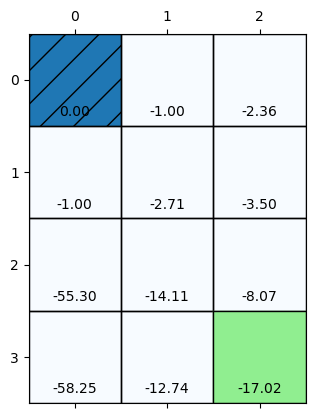

In [44]:
fig, ax = plt.subplots(ncols=1)
gw.render(agent.q.max(axis=1),ax)

The results do not seem so good yet, let us try with longer training and gamma = 0.9

In [45]:
env = MDPEnv(gw.states, gw.NR_ACTIONS, 11)
agent = MonteCarloAgentFirstVisit(env.action_space, env.observation_space, gamma=0.9, epsilon=0.1)
agent.reset()
agent.train(env, 10000)

100%|██████████| 10000/10000 [00:02<00:00, 4293.05it/s]


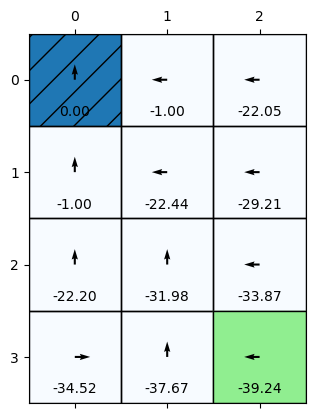

In [46]:
p_greedy = greedy_from_action_values(agent.q)
plot_policy_values(p_greedy, q.max(axis=1), gw)

As the last experiment, we want to try the MC algorithm on the slippery gridworld from the last exercise. 

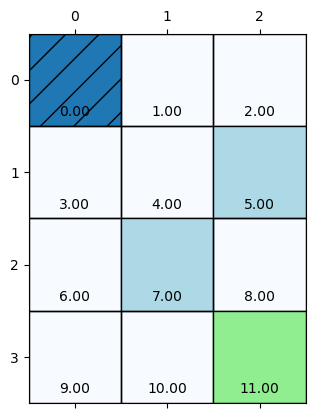

In [47]:
gws = SlipperyGridworld(4, 3)
gws.state(0,0).is_terminal = True
gws.state(3,2).color = 'lightgreen'

gws.add_wall(0,0,1,0)
gws.add_slippery_patch(1,2, 0.4)
gws.add_slippery_patch(2,1, 0.5)

fig, ax = plt.subplots()
gws.render(gws.all_state_ids(), ax)

100%|██████████| 10000/10000 [00:03<00:00, 2795.19it/s]


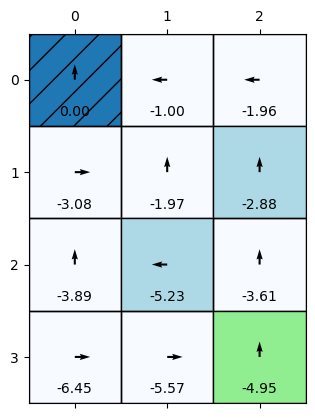

In [48]:
env = MDPEnv(gws.states, gws.NR_ACTIONS, 11)
agent = MonteCarloAgentFirstVisit(env.action_space, env.observation_space, gamma=0.9, epsilon=0.1)
agent.reset()
agent.train(env, 10000)
p_greedy = greedy_from_action_values(agent.q)
plot_policy_values(p_greedy, agent.q.max(axis=1), gws)

How does this compare to the algorithm from last week? 

This is all for the exercise. 